In [69]:
import numpy as np
import nibabel as nib
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

## Part 1 — Load data + sanity checks
We load the cropped hippocampus T1 scan and its subfield labelmap, then verify shapes, voxel sizes, and label values.


In [70]:
import numpy as np
import nibabel as nib

img_path = "/Users/karimelsayed/Desktop/sub-HC005_ses-01_hemi-L_space-cropT1w_desc-preproc_T1w.nii.gz"
lbl_path = "/Users/karimelsayed/Desktop/sub-HC005_ses-01_hemi-L_space-cropT1w_label-hipp_desc-subfields_atlas-multihist7_dseg.nii.gz"

img_obj = nib.load(img_path)
lbl_obj = nib.load(lbl_path)

img = img_obj.get_fdata().astype(float)
lbl = lbl_obj.get_fdata().astype(int)

print("Image shape:", img.shape)
print("Label shape:", lbl.shape)
print("Voxel sizes (img):", img_obj.header.get_zooms())
print("Voxel sizes (lbl):", lbl_obj.header.get_zooms())
print("Unique labels:", np.unique(lbl))


Image shape: (256, 256, 256)
Label shape: (256, 256, 256)
Voxel sizes (img): (np.float32(0.19591859), np.float32(0.19813085), np.float32(0.1957447))
Voxel sizes (lbl): (np.float32(0.19591859), np.float32(0.19813085), np.float32(0.1957447))
Unique labels: [0 1 2 3 4 5 6 7 8]


## Part 2 — Visualize baseline (copied from Farhan)
We reuse Farhan’s 4-panel viewer (full slice + overlay + zoom + zoom overlay).
Then we auto-select a slice centered on hippocampal cortex (labels 1–6).

In [71]:
import matplotlib.pyplot as plt

def show_brain_views_from_arrays(img, labelmap, slice_index=None,
                                 zoom_size_vox=(160, 160),
                                 center_rc=None,
                                 highlight_label=None,
                                 title_prefix=""):

    Z, Y, X = img.shape
    if slice_index is None:
        slice_index = Z // 2

    img2d = img[slice_index, :, :]
    lbl2d = labelmap[slice_index, :, :]

    if center_rc is None:
        center_rc = (Y//2, X//2)

    r0 = max(0, center_rc[0] - zoom_size_vox[0]//2)
    c0 = max(0, center_rc[1] - zoom_size_vox[1]//2)
    r1, c1 = r0 + zoom_size_vox[0], c0 + zoom_size_vox[1]

    img_zoom = img2d[r0:r1, c0:c1]
    lbl_zoom = lbl2d[r0:r1, c0:c1]

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    if title_prefix:
        fig.suptitle(f"{title_prefix} (Slice {slice_index})", fontsize=14)

    axes[0,0].imshow(img2d, cmap="gray", origin="lower")
    axes[0,0].set_title("Full Slice")

    masked_lbl = np.ma.masked_where(lbl2d == 0, lbl2d)
    axes[0,1].imshow(img2d, cmap="gray", origin="lower")
    axes[0,1].imshow(masked_lbl, cmap="tab20", alpha=0.5, origin="lower")
    if highlight_label is not None:
        hl_mask = np.ma.masked_where(lbl2d != highlight_label, lbl2d)
        axes[0,1].imshow(hl_mask, cmap="autumn", alpha=0.8, origin="lower")
    axes[0,1].set_title("With Label Overlay")

    axes[1,0].imshow(img_zoom, cmap="gray", origin="lower")
    axes[1,0].set_title("Zoomed Region")

    masked_lbl_z = np.ma.masked_where(lbl_zoom == 0, lbl_zoom)
    axes[1,1].imshow(img_zoom, cmap="gray", origin="lower")
    axes[1,1].imshow(masked_lbl_z, cmap="tab20", alpha=0.5, origin="lower")
    if highlight_label is not None:
        hl_mask_z = np.ma.masked_where(lbl_zoom != highlight_label, lbl_zoom)
        axes[1,1].imshow(hl_mask_z, cmap="autumn", alpha=0.8, origin="lower")
    axes[1,1].set_title("Zoomed + Labels")

    plt.tight_layout()
    plt.show()


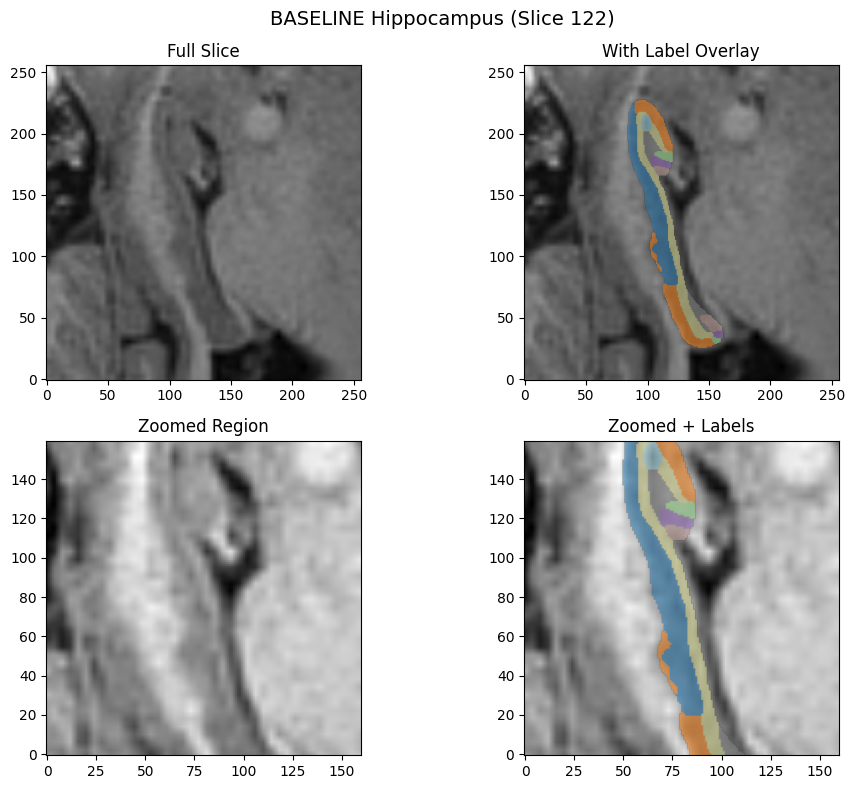

In [72]:
hc_mask = np.isin(lbl, [1,2,3,4,5,6])
coords = np.argwhere(hc_mask)

z_center = int(np.median(coords[:, 0]))
rc_center = (int(np.median(coords[:, 1])), int(np.median(coords[:, 2])))

show_brain_views_from_arrays(
    img, lbl,
    slice_index=z_center,
    center_rc=rc_center,
    title_prefix="BASELINE Hippocampus"
)


## Part 3 — Hippocampus Characteristics
Compute volumes per label and summarize structure.

In [73]:
voxel_vol = np.prod(img_obj.header.get_zooms())

print("Voxel volume (mm^3):", voxel_vol)

volumes = {}

for k in range(1,9):
    v = np.sum(lbl == k) * voxel_vol
    volumes[k] = v
    print(f"Label {k} volume (mm^3): {v:.2f}")

hc_cortex_vol = sum(volumes[k] for k in [1,2,3,4,5,6])
print("\nTotal hippocampal cortex volume (1–6):", round(hc_cortex_vol,2))
print("SRLM volume (7):", round(volumes[7],2))
print("Cyst volume (8):", round(volumes[8],2))


Voxel volume (mm^3): 0.007598323
Label 1 volume (mm^3): 690.06
Label 2 volume (mm^3): 897.16
Label 3 volume (mm^3): 92.06
Label 4 volume (mm^3): 150.04
Label 5 volume (mm^3): 138.42
Label 6 volume (mm^3): 155.88
Label 7 volume (mm^3): 575.76
Label 8 volume (mm^3): 12.35

Total hippocampal cortex volume (1–6): 2123.62
SRLM volume (7): 575.76
Cyst volume (8): 12.35


## Part 4 — Thinning (copied from Farhan’s deformation engine)

We reuse Farhan’s gradient-flow deformation function (`warp_from_mask`).

Differences for our project:
- We do NOT generate a random lesion mask.
- We use the hippocampal cortex mask (labels 1–6).
- We apply a NEGATIVE radius to simulate thinning.

BASELINE:
  voxel_vol(mm^3): 0.007598322816193104
  cortex(1–6): 2123.62 | SRLM(7): 575.76 | cyst(8): 12.35

RUNNING PART 4 (Thinning + Global Shrink IMAGE ONLY):

[MILD] thin_radius=-0.6  scale_xyz=(0.96, 1.0, 0.94)
  cortex(1–6): 1706.46 delta: -417.16
  SRLM(7): 719.38 delta: 143.62
  cyst(8): 15.07 delta: 2.71
Saved: /Users/karimelsayed/Desktop/hipp_outputs/atrophy_mild_T1.nii.gz
Saved: /Users/karimelsayed/Desktop/hipp_outputs/atrophy_mild_labels.nii.gz

[MEDIUM] thin_radius=-1.0  scale_xyz=(0.93, 1.0, 0.9)
  cortex(1–6): 1584.49 delta: -539.13
  SRLM(7): 773.76 delta: 198.0
  cyst(8): 16.04 delta: 3.69
Saved: /Users/karimelsayed/Desktop/hipp_outputs/atrophy_medium_T1.nii.gz
Saved: /Users/karimelsayed/Desktop/hipp_outputs/atrophy_medium_labels.nii.gz

[STRONG] thin_radius=-1.4  scale_xyz=(0.9, 1.0, 0.86)
  cortex(1–6): 1506.94 delta: -616.67
  SRLM(7): 803.61 delta: 227.86
  cyst(8): 16.53 delta: 4.18
Saved: /Users/karimelsayed/Desktop/hipp_outputs/atrophy_strong_T1.nii.gz
Saved: /

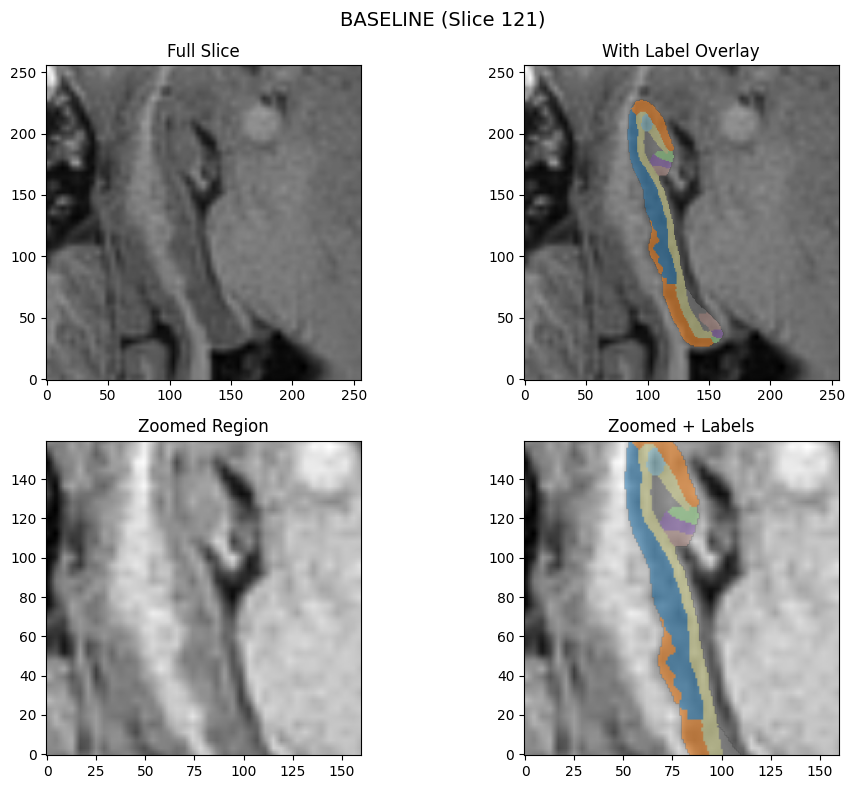

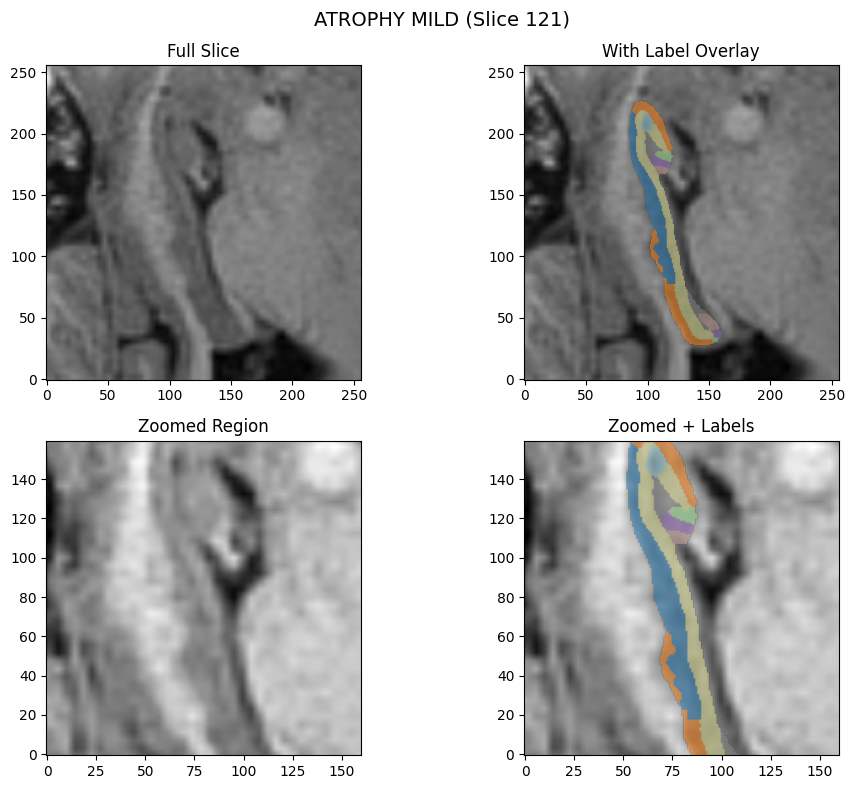

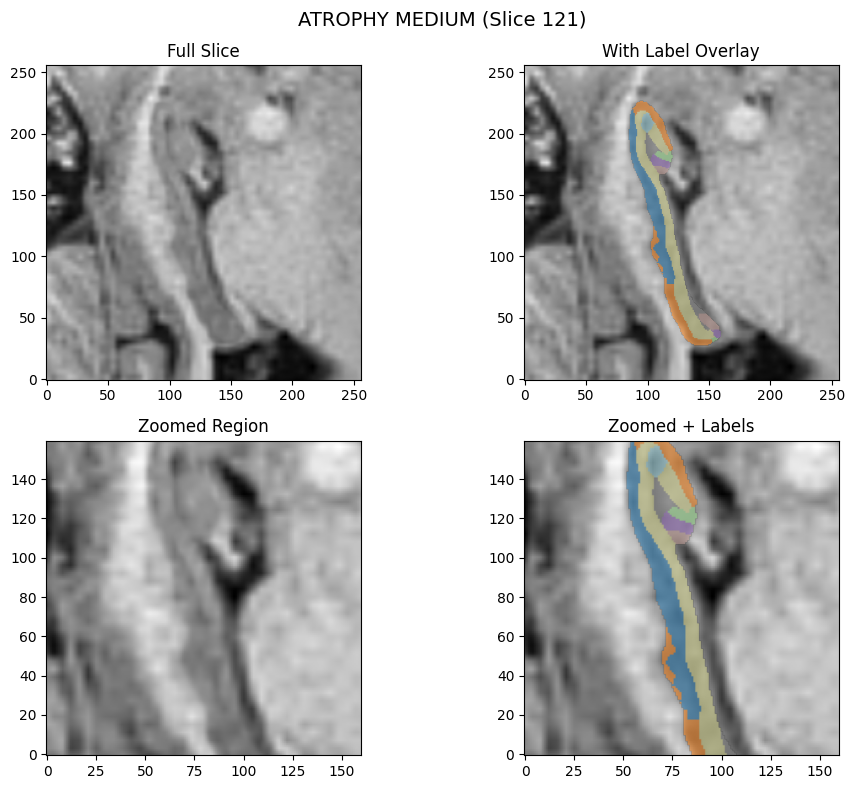

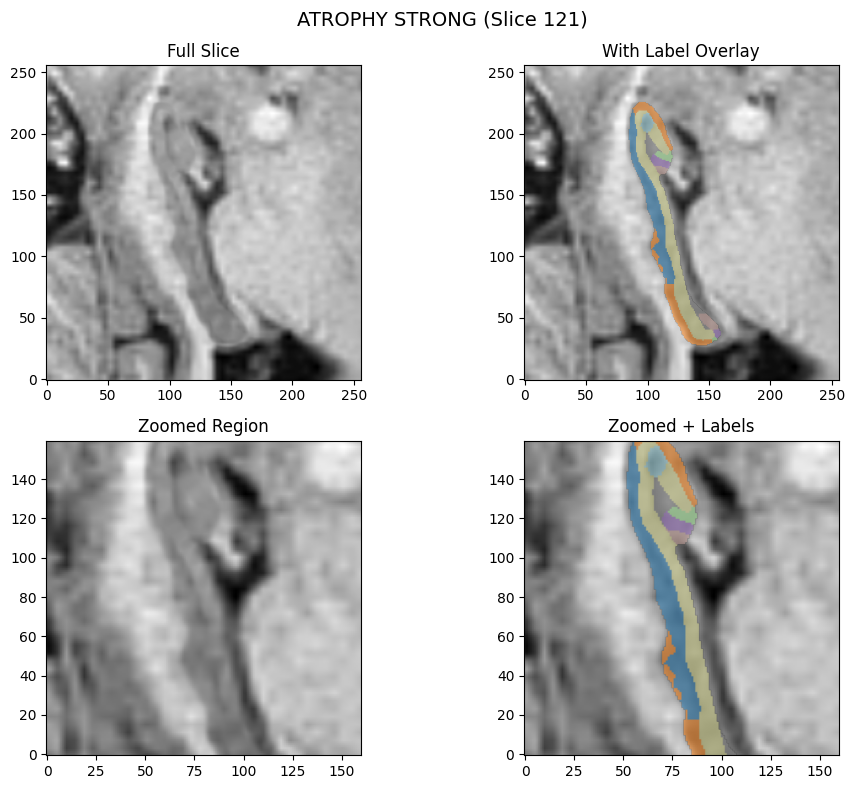

In [74]:
# ============================================================
# Part 4 — Atrophy simulation (PI version) — FIXED
#
# Goal (as PI described):
#   A) Thinning: hippocampal cortex ribbon gets thinner (labels 1–6)  [Farhan-style]
#   B) Global shrinking: whole hippocampus looks smaller overall      [Affine scale]
#
# IMPORTANT FIX:
#   - We DO NOT apply global shrinking to the LABELMAP (it breaks monotonic volumes via NN relabeling).
#   - We apply global shrinking to the IMAGE ONLY.
#   - Labels come from thinning only, so cortex volumes decrease nicely with severity.
#
# Outputs:
#   - atrophy_{mild|medium|strong}_T1.nii.gz  (thinned + globally shrunk image)
#   - atrophy_{mild|medium|strong}_labels.nii.gz (thinned labels only)
# ============================================================

import os
import numpy as np
import nibabel as nib
import SimpleITK as sitk
from scipy.ndimage import gaussian_filter

# ---------- Farhan-style thinning engine ----------
def warp_from_mask(img_np, lbl_np, mask_np, spacing_xyz, radius_mm, smooth_sigma=1.5):
    ref = sitk.GetImageFromArray(lbl_np.astype(np.int16))
    ref.SetSpacing(tuple(float(s) for s in spacing_xyz))

    img_sitk = sitk.GetImageFromArray(img_np.astype(np.float32)); img_sitk.CopyInformation(ref)
    lbl_sitk = sitk.GetImageFromArray(lbl_np.astype(np.int16));  lbl_sitk.CopyInformation(ref)

    mask_smooth = gaussian_filter(mask_np.astype(np.float32), sigma=float(smooth_sigma))
    gz, gy, gx = np.gradient(mask_smooth)

    dx = gx * float(radius_mm)
    dy = gy * float(radius_mm)
    dz = gz * float(radius_mm)

    dx_img = sitk.GetImageFromArray(dx.astype(np.float64)); dx_img.CopyInformation(ref)
    dy_img = sitk.GetImageFromArray(dy.astype(np.float64)); dy_img.CopyInformation(ref)
    dz_img = sitk.GetImageFromArray(dz.astype(np.float64)); dz_img.CopyInformation(ref)

    disp_field = sitk.Compose(dx_img, dy_img, dz_img)
    tfm = sitk.DisplacementFieldTransform(disp_field)

    res = sitk.ResampleImageFilter()
    res.SetReferenceImage(img_sitk)
    res.SetTransform(tfm)

    res.SetInterpolator(sitk.sitkLinear)
    img_warp = res.Execute(img_sitk)

    res.SetInterpolator(sitk.sitkNearestNeighbor)
    lbl_warp = res.Execute(lbl_sitk)

    return sitk.GetArrayFromImage(img_warp), sitk.GetArrayFromImage(lbl_warp)

# ---------- Global shrink (IMAGE ONLY) ----------
def global_shrink_image_only(img_np, spacing_xyz, scale_xyz, center_zyx, like_lbl_np):
    ref = sitk.GetImageFromArray(like_lbl_np.astype(np.int16))
    ref.SetSpacing(tuple(float(s) for s in spacing_xyz))

    img_s = sitk.GetImageFromArray(img_np.astype(np.float32)); img_s.CopyInformation(ref)

    cz, cy, cx = [float(v) for v in center_zyx]
    center_phys = ref.TransformContinuousIndexToPhysicalPoint((cx, cy, cz))

    sx, sy, sz = [float(v) for v in scale_xyz]
    aff = sitk.AffineTransform(3)
    aff.SetCenter(center_phys)
    aff.SetMatrix([sx, 0,  0,
                   0,  sy, 0,
                   0,  0,  sz])

    res = sitk.ResampleImageFilter()
    res.SetReferenceImage(img_s)
    res.SetTransform(aff)
    res.SetInterpolator(sitk.sitkLinear)
    img_out = res.Execute(img_s)

    return sitk.GetArrayFromImage(img_out)

# ---------- saving + volumes ----------
def save_nifti_like(arr_np, ref_nib, out_path, dtype=None):
    if dtype is not None:
        arr_np = arr_np.astype(dtype)
    out = nib.Nifti1Image(arr_np, affine=ref_nib.affine, header=ref_nib.header)
    nib.save(out, out_path)
    print("Saved:", out_path)

def volumes_mm3(lbl_arr, voxel_vol_local):
    vols = {k: float(np.sum(lbl_arr == k) * voxel_vol_local) for k in range(1, 9)}
    vols["cortex_1to6"] = float(sum(vols[k] for k in [1,2,3,4,5,6]))
    return vols

# ---------- geometry + masks ----------
spacing = img_obj.header.get_zooms()
voxel_vol_local = float(np.prod(spacing))

cortex_mask = np.isin(lbl, [1,2,3,4,5,6]).astype(np.uint8)
hippo_mask  = np.isin(lbl, [1,2,3,4,5,6,7,8])
coords = np.argwhere(hippo_mask)

z_center_local = int(np.median(coords[:,0]))
rc_center_local = (int(np.median(coords[:,1])), int(np.median(coords[:,2])))
center_zyx = (np.median(coords[:,0]), np.median(coords[:,1]), np.median(coords[:,2]))

# ---------- severity presets ----------
severity = {
    "mild":   {"thin_radius": -0.6, "scale_xyz": (0.96, 1.00, 0.94)},
    "medium": {"thin_radius": -1.0, "scale_xyz": (0.93, 1.00, 0.90)},
    "strong": {"thin_radius": -1.4, "scale_xyz": (0.90, 1.00, 0.86)},
}

out_dir = "/Users/karimelsayed/Desktop/hipp_outputs"
os.makedirs(out_dir, exist_ok=True)

# ---------- baseline report ----------
base_vols = volumes_mm3(lbl, voxel_vol_local)
print("BASELINE:")
print("  voxel_vol(mm^3):", voxel_vol_local)
print("  cortex(1–6):", round(base_vols["cortex_1to6"],2),
      "| SRLM(7):", round(base_vols[7],2),
      "| cyst(8):", round(base_vols[8],2))

# ---------- run pipeline ----------
results = {}

print("\nRUNNING PART 4 (Thinning + Global Shrink IMAGE ONLY):")
for name, cfg in severity.items():
    # A) Thinning (labels + image) — Farhan style
    img_t, lbl_t = warp_from_mask(
        img_np=img,
        lbl_np=lbl,
        mask_np=cortex_mask,
        spacing_xyz=spacing,
        radius_mm=cfg["thin_radius"],
        smooth_sigma=1.5
    )

    # B) Global shrinking (IMAGE ONLY)
    img_s = global_shrink_image_only(
        img_np=img_t,
        spacing_xyz=spacing,
        scale_xyz=cfg["scale_xyz"],
        center_zyx=center_zyx,
        like_lbl_np=lbl_t
    )

    # Labels stay as thinned labels (monotonic cortex volumes)
    lbl_s = lbl_t

    results[name] = (img_s, lbl_s)

    v = volumes_mm3(lbl_s, voxel_vol_local)
    print(f"\n[{name.upper()}] thin_radius={cfg['thin_radius']}  scale_xyz={cfg['scale_xyz']}")
    print("  cortex(1–6):", round(v["cortex_1to6"],2), "delta:", round(v["cortex_1to6"]-base_vols["cortex_1to6"],2))
    print("  SRLM(7):", round(v[7],2), "delta:", round(v[7]-base_vols[7],2))
    print("  cyst(8):", round(v[8],2), "delta:", round(v[8]-base_vols[8],2))

    save_nifti_like(img_s, img_obj, os.path.join(out_dir, f"atrophy_{name}_T1.nii.gz"), dtype=np.float32)
    save_nifti_like(lbl_s, lbl_obj, os.path.join(out_dir, f"atrophy_{name}_labels.nii.gz"), dtype=np.int16)

# ---------- visualize ----------
print("\nVISUAL QC:")
show_brain_views_from_arrays(img, lbl, slice_index=z_center_local, center_rc=rc_center_local, title_prefix="BASELINE")

for name in ["mild", "medium", "strong"]:
    img_s, lbl_s = results[name]
    show_brain_views_from_arrays(img_s, lbl_s, slice_index=z_center_local, center_rc=rc_center_local, title_prefix=f"ATROPHY {name.upper()}")


## Part 5 - Cyst inclusion


RUNNING PART 5 (Cyst insertion — OPTION 1 improved, inside SRLM label 7):

[MILD] requested_cysts=2  size_range(vox)=200..1200
  cortex(1–6): 1706.46
  SRLM(7): 703.15
  cyst(8): 31.3 | cyst-only delta: 16.23
   - cyst1: placed_vox=1015 inside_frac=0.969 n_shrinks=0 center_zyx=[123, 39, 141]
   - cyst2: placed_vox=1121 inside_frac=0.952 n_shrinks=0 center_zyx=[133, 210, 93]
Saved: /Users/karimelsayed/Desktop/hipp_outputs/atrophy_mild_labels_with_cysts.nii.gz


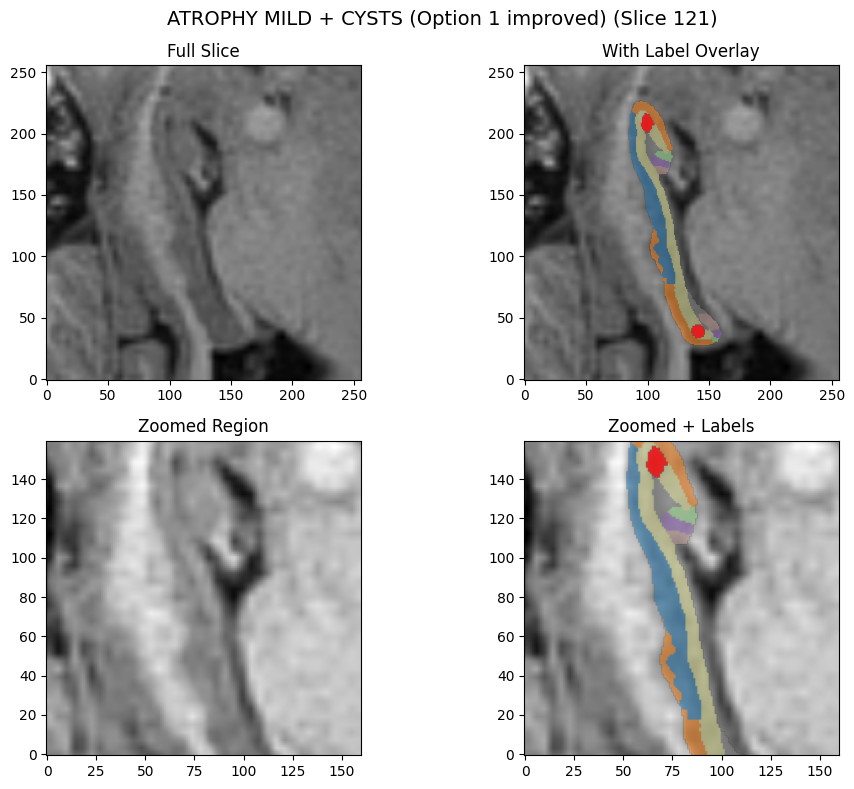


[MEDIUM] requested_cysts=3  size_range(vox)=300..1600
  cortex(1–6): 1584.49
  SRLM(7): 747.99
  cyst(8): 41.81 | cyst-only delta: 25.77
   - cyst1: placed_vox=1292 inside_frac=1.000 n_shrinks=0 center_zyx=[154, 199, 104]
   - cyst2: placed_vox=1057 inside_frac=1.000 n_shrinks=0 center_zyx=[108, 202, 103]
   - cyst3: placed_vox=1043 inside_frac=0.946 n_shrinks=0 center_zyx=[112, 100, 114]
Saved: /Users/karimelsayed/Desktop/hipp_outputs/atrophy_medium_labels_with_cysts.nii.gz


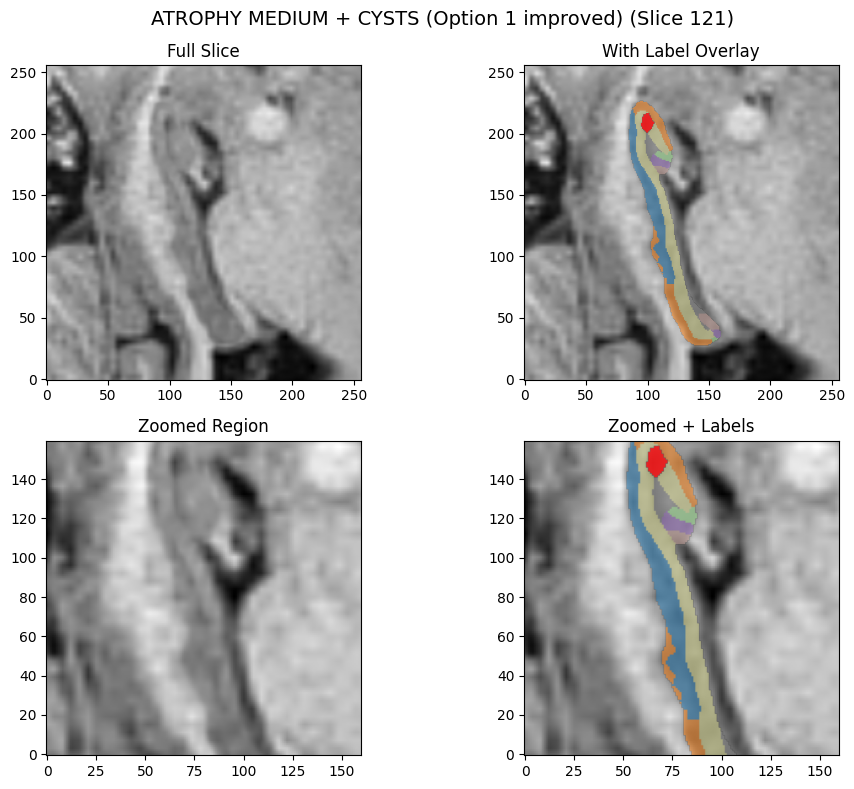


[STRONG] requested_cysts=2  size_range(vox)=400..2000
  cortex(1–6): 1506.94
  SRLM(7): 790.78
  cyst(8): 29.37 | cyst-only delta: 12.83
   - cyst1: placed_vox=424 inside_frac=0.959 n_shrinks=0 center_zyx=[148, 205, 102]
   - cyst2: placed_vox=1265 inside_frac=0.959 n_shrinks=0 center_zyx=[129, 37, 144]
Saved: /Users/karimelsayed/Desktop/hipp_outputs/atrophy_strong_labels_with_cysts.nii.gz


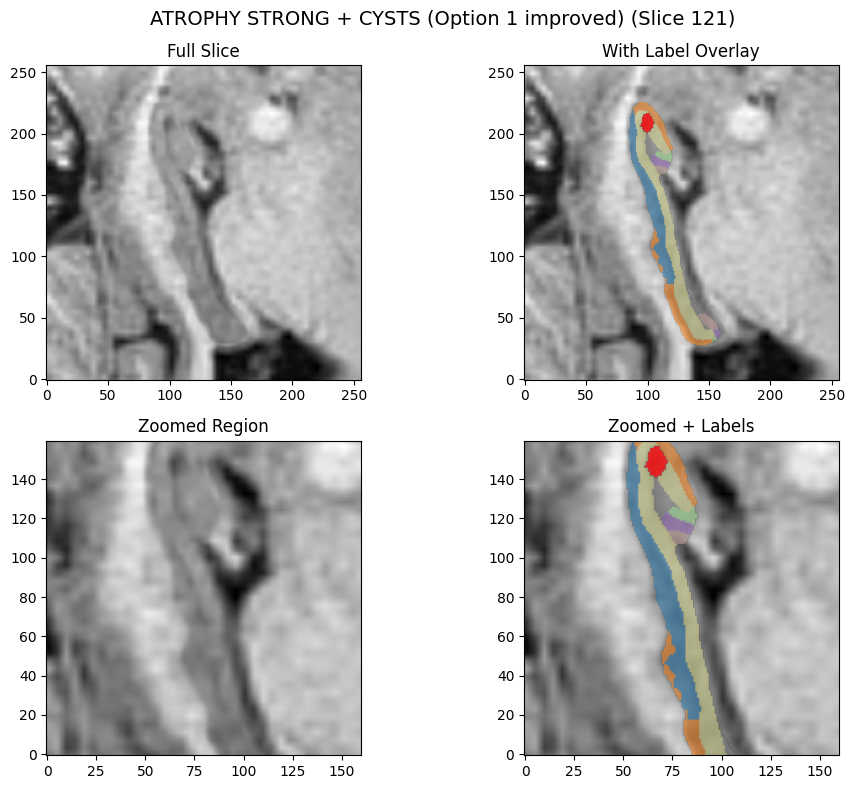

In [76]:
# ============================================================
# Part 5 — Cyst simulation (OPTION 1: "carve a hole") — IMPROVED + PI-CORRECT
#
# PI requirement:
#   - Cysts should appear inside SRLM / hippocampal sulcus (label 7)
#   - Cyst voxels are assigned label 8
#
# Improvements vs baseline:
#   1) Places cyst centers ONLY in "deep SRLM" (distance-to-boundary >= min_center_dist_vox)
#      -> reduces clipped/flat cyst shapes
#   2) If inside_fraction is too low, we SHRINK radii and retry (instead of ugly fallback)
#   3) Severity-aware cyst burden (n_cysts + size range scale with mild/medium/strong)
#   4) Avoids overlap with existing cysts AND between newly placed cysts
#   5) Prints cyst-only delta (before vs after) + saves labels + QC viewer
#
# Changes ONLY the LABELMAP (sets some label-7 voxels to label-8). IMAGE unchanged.
#
# Assumes from previous parts:
#   - results dict: results["mild"|"medium"|"strong"] = (img_s, lbl_s)
#   - img_obj, lbl_obj, out_dir
#   - show_brain_views_from_arrays(...)
#   - z_center_local, rc_center_local
#   - volumes_mm3(lbl, voxel_vol_mm3) -> dict with keys: 7, 8, "cortex_1to6"
#   - save_nifti_like(arr, like_nib, out_path, dtype=...)
#   - spacing_zyx and voxel_vol_local are consistent with your Part 4 arrays
# ============================================================

import os
import numpy as np
from scipy.ndimage import distance_transform_edt

# ---------- helpers ----------
def _make_ellipsoid_mask(center_zyx, radii_zyx_vox, shape_zyx):
    cz, cy, cx = [float(v) for v in center_zyx]
    rz, ry, rx = [float(v) for v in radii_zyx_vox]
    Z, Y, X = shape_zyx

    z0 = max(0, int(np.floor(cz - rz)))
    z1 = min(Z, int(np.ceil(cz + rz + 1)))
    y0 = max(0, int(np.floor(cy - ry)))
    y1 = min(Y, int(np.ceil(cy + ry + 1)))
    x0 = max(0, int(np.floor(cx - rx)))
    x1 = min(X, int(np.ceil(cx + rx + 1)))

    zz = np.arange(z0, z1, dtype=float)[:, None, None]
    yy = np.arange(y0, y1, dtype=float)[None, :, None]
    xx = np.arange(x0, x1, dtype=float)[None, None, :]

    rz = max(rz, 1e-6); ry = max(ry, 1e-6); rx = max(rx, 1e-6)

    eq = ((zz - cz) / rz) ** 2 + ((yy - cy) / ry) ** 2 + ((xx - cx) / rx) ** 2
    local = eq <= 1.0

    mask = np.zeros(shape_zyx, dtype=bool)
    mask[z0:z1, y0:y1, x0:x1] = local
    return mask

def _radii_from_target_voxels(target_vox, spacing_zyx, rng):
    # spacing_zyx in mm for (Z,Y,X)
    sz, sy, sx = [float(v) for v in spacing_zyx]
    voxel_vol_mm3 = sx * sy * sz
    target_mm3 = float(target_vox) * voxel_vol_mm3

    # mild anisotropy
    az, ay, ax = rng.uniform(1.0, 1.8, size=3)

    # V = 4/3*pi*rz*ry*rx (mm^3)
    r_mm = ((3.0 * target_mm3) / (4.0 * np.pi * (az * ay * ax))) ** (1.0 / 3.0)
    rz_mm, ry_mm, rx_mm = r_mm * az, r_mm * ay, r_mm * ax

    radii_zyx_vox = np.array([rz_mm / sz, ry_mm / sy, rx_mm / sx], dtype=float)
    radii_zyx_vox = np.maximum(radii_zyx_vox, 1.5)
    return radii_zyx_vox

def _deep_srlm_center_coords(lbl_np, srlm_label=7, min_center_dist_vox=2.0):
    """
    Returns coords (z,y,x) inside SRLM that are at least min_center_dist_vox
    away from the SRLM boundary (in voxel units).
    """
    srlm = (lbl_np == srlm_label)
    if srlm.sum() == 0:
        return np.zeros((0,3), dtype=int)

    # distance to boundary inside SRLM: distance to nearest non-SRLM voxel
    # edt computes distance to zeros, so we pass ~srlm as zeros via srlm.astype
    dist_inside = distance_transform_edt(srlm.astype(np.uint8))

    deep = srlm & (dist_inside >= float(min_center_dist_vox))
    coords = np.argwhere(deep)
    return coords

def add_cysts_option1(lbl_np,
                      spacing_zyx,
                      cyst_label=8,
                      srlm_label=7,
                      n_cysts=2,
                      cyst_size_vox_range=(200, 1500),
                      seed=0,
                      min_inside_fraction=0.92,
                      max_tries_per_cyst=600,
                      min_center_dist_vox=2.0,
                      shrink_factor=0.85,
                      max_shrinks=6):
    rng = np.random.default_rng(seed)

    # placement is INSIDE SRLM label 7
    place_mask = (lbl_np == srlm_label)
    if place_mask.sum() == 0:
        raise ValueError("No SRLM (label 7) voxels found.")

    # choose centers only from "deep SRLM" to avoid clipping
    coords = _deep_srlm_center_coords(lbl_np, srlm_label=srlm_label, min_center_dist_vox=min_center_dist_vox)
    if coords.size == 0:
        # fallback to any SRLM voxel if SRLM is thin
        coords = np.argwhere(place_mask)

    out = lbl_np.copy()

    # avoid overlap with existing cysts
    occupied = (out == cyst_label)

    meta = {"n_cysts": int(n_cysts), "placed": []}

    vmin, vmax = cyst_size_vox_range

    for i in range(int(n_cysts)):
        target_vox = int(rng.integers(vmin, vmax + 1))
        base_radii = _radii_from_target_voxels(target_vox, spacing_zyx, rng)

        placed = False

        # Try multiple "radius scales" (shrink if cyst doesn't fit cleanly)
        radii = base_radii.copy()
        for shrink_i in range(max_shrinks + 1):
            best = None
            best_frac = -1.0

            for _ in range(max_tries_per_cyst):
                center = coords[int(rng.integers(0, len(coords)))]
                ell = _make_ellipsoid_mask(center, radii, out.shape)

                # prevent overlap
                ell = ell & (~occupied)
                ell_vox = int(ell.sum())
                if ell_vox == 0:
                    continue

                inside = ell & place_mask
                inside_vox = int(inside.sum())
                frac_inside = inside_vox / float(ell_vox)

                if frac_inside > best_frac:
                    best_frac = frac_inside
                    best = (center.copy(), inside.copy(), inside_vox, frac_inside, radii.copy())

                if frac_inside >= min_inside_fraction:
                    out[inside] = cyst_label
                    occupied |= inside
                    meta["placed"].append({
                        "center_zyx": center.tolist(),
                        "target_vox": target_vox,
                        "placed_vox": inside_vox,
                        "inside_fraction": float(frac_inside),
                        "radii_zyx_vox": radii.tolist(),
                        "n_shrinks": int(shrink_i)
                    })
                    placed = True
                    break

            if placed:
                break

            # Didn't meet inside_fraction, shrink radii and retry
            radii = radii * float(shrink_factor)

            # stop if cyst becomes too small to matter
            if radii.min() < 1.2:
                break

        if not placed:
            # final fallback: place best attempt IF it exists and isn't terrible
            if best is not None and best[3] >= 0.85:
                center, inside, inside_vox, frac_inside, radii_used = best
                out[inside] = cyst_label
                occupied |= inside
                meta["placed"].append({
                    "center_zyx": center.tolist(),
                    "target_vox": target_vox,
                    "placed_vox": inside_vox,
                    "inside_fraction": float(frac_inside),
                    "radii_zyx_vox": radii_used.tolist(),
                    "n_shrinks": int(max_shrinks),
                    "note": "fallback used (best attempt < min_inside_fraction, but >= 0.85)"
                })
            else:
                meta["placed"].append({
                    "target_vox": target_vox,
                    "note": "FAILED to place cyst (SRLM too thin or constraints too strict)"
                })

    return out, meta

# ============================================================
# Run Part 5 on each atrophy severity output (mild/medium/strong)
# ============================================================

# Keep spacing consistent with Part 4 (Z,Y,X array axes)
voxel_vol_local = float(np.prod(spacing_zyx))

# severity-aware settings (tune these)
severity_cfg = {
    "mild":   {"n_range": (1, 2), "size_range": (200, 1200), "seed": 0},
    "medium": {"n_range": (1, 3), "size_range": (300, 1600), "seed": 100},
    "strong": {"n_range": (2, 4), "size_range": (400, 2000), "seed": 200},
}

MIN_INSIDE = 0.92
MIN_CENTER_DIST = 2.0

print("\nRUNNING PART 5 (Cyst insertion — OPTION 1 improved, inside SRLM label 7):")
for name in ["mild", "medium", "strong"]:
    img_s, lbl_s = results[name]

    cfg = severity_cfg[name]
    n_cysts = int(np.random.default_rng(cfg["seed"]).integers(cfg["n_range"][0], cfg["n_range"][1] + 1))

    # measure cyst volume BEFORE insertion (existing label-8)
    v_before = volumes_mm3(lbl_s, voxel_vol_local)
    cyst_before = float(v_before[8])

    lbl_c, meta = add_cysts_option1(
        lbl_np=lbl_s,
        spacing_zyx=spacing_zyx,
        cyst_label=8,
        srlm_label=7,
        n_cysts=n_cysts,
        cyst_size_vox_range=cfg["size_range"],
        seed=cfg["seed"],
        min_inside_fraction=MIN_INSIDE,
        max_tries_per_cyst=600,
        min_center_dist_vox=MIN_CENTER_DIST,
        shrink_factor=0.85,
        max_shrinks=6
    )

    v_after = volumes_mm3(lbl_c, voxel_vol_local)
    cyst_after = float(v_after[8])

    print(f"\n[{name.upper()}] requested_cysts={n_cysts}  size_range(vox)={cfg['size_range'][0]}..{cfg['size_range'][1]}")
    print("  cortex(1–6):", round(v_after["cortex_1to6"], 2))
    print("  SRLM(7):", round(v_after[7], 2))
    print("  cyst(8):", round(cyst_after, 2), "| cyst-only delta:", round(cyst_after - cyst_before, 2))

    for i, c in enumerate(meta["placed"], 1):
        if "center_zyx" in c:
            note = (" | " + c["note"]) if "note" in c else ""
            print(f"   - cyst{i}: placed_vox={c['placed_vox']} inside_frac={c['inside_fraction']:.3f} "
                  f"n_shrinks={c['n_shrinks']} center_zyx={c['center_zyx']}{note}")
        else:
            print(f"   - cyst{i}: {c.get('note','(no details)')} target_vox={c.get('target_vox','?')}")

    # save updated labels (image unchanged)
    save_nifti_like(lbl_c, lbl_obj, os.path.join(out_dir, f"atrophy_{name}_labels_with_cysts.nii.gz"), dtype=np.int16)

    # QC visualize cyst label 8
    show_brain_views_from_arrays(
        img_s, lbl_c,
        slice_index=z_center_local,
        center_rc=rc_center_local,
        highlight_label=8,
        title_prefix=f"ATROPHY {name.upper()} + CYSTS (Option 1 improved)")